In [4]:
import numpy as np
import pystac_client
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from myFunction import *
pc.settings.set_subscription_key('f5d5701b67db46ffaf0a0cb80412ef3e')  

In [5]:
def dateTime_to_second_one_row(arr):
    '''
    Transform a array of date time into an array of second
    
    Args:
        arr  (ndarray): A 1D array of date time, axis 0 is sample and axis 1 is date
        
    Return:
        arr2 (ndarray): A 1D array of second, axis 0 is sample and axis 1 is date
    '''
    epoch = arr.min()
    div = np.timedelta64(1, "s")
    arr2 = np.zeros(arr.shape)
    arr2 = (arr - epoch) / div
    del epoch, arr, div
    return arr2

def get_backgound_image(settings):
    print("Get background image")
    lat = settings["lat"]
    lon = settings["lon"]
    bbox = get_box(lat, lon, settings["window_box_size_deg"])
    item = list(settings["catalog"].search(collections=["sentinel-2-l2a"], bbox=bbox, datetime="2022-01-01/2022-02-28").item_collection())
    data = stac_load(item, bands=["red", "green", "blue"], crs="EPSG:4326", resolution=settings["background scale"], dtype="uint16", patch_url=pc.sign, bbox=bbox)
    im = np.moveaxis(data[["red", "green", "blue"]].to_array().to_numpy(), 0, -1)
    im2 = np.zeros(im.shape)
    for i, j in enumerate(im):
        im2[i, :, :, 0] = (j[:, :, 0] - j[:, :, 0].min()) / (j[:, :, 0].max() - j[:, :, 0].min())
        im2[i, :, :, 1] = (j[:, :, 1] - j[:, :, 1].min()) / (j[:, :, 1].max() - j[:, :, 1].min())
        im2[i, :, :, 2] = (j[:, :, 2] - j[:, :, 2].min()) / (j[:, :, 2].max() - j[:, :, 2].min())
    date = data.time.to_numpy()
    del data, item, bbox, lat, lon, im
    return im2

def get_full_window_rvi_no_pred(settings):
    print("Get rvi image")
    lat = settings["lat"]
    lon = settings["lon"]
    bbox = get_box(lat, lon, settings["window_box_size_deg"])
    item = list(settings["catalog"].search(collections=["sentinel-1-rtc"], bbox=bbox, datetime=settings["time_of_interest"]).item_collection())
    data = stac_load(item, bands=["vv", "vh"], patch_url=pc.sign, bbox=bbox, crs="EPSG:4326", resolution=settings["RVI scale"])
    rvi = ((np.sqrt((data.vv / (data.vv + data.vh))))*((4*data.vh)/(data.vv + data.vh))).to_numpy()
    date = data.time.to_numpy()
    return rvi, date

def check_boundary(x, shape):
    if 0 <= x <= shape+1: return x
    elif x > shape+1: return shape+1
    else: return 0

def get_color(pred):
    if pred > 0.70:
        color = (0, 1, 0)
    elif pred < 0.30:
        color = (1, 0, 0)
    else:
        color = (1, 1, 0)
    return color

def get_color2(pred):
    return (1-pred, pred, 0)

def get_color_softmax(pred):
    if pred[0] > 0.7:
        return (0, 1, 0)
    elif pred[1] > 0.7:
        return (0, 1, 0)
    elif pred[2] > 0.7:
        return (1, 0, 0)
    else:
        return (1, 1, 0)

def rvi_im2cat_mask(rvi, date, box_size=5):
    print("Get mask")
    rvis = np.zeros((rvi.shape[1]*rvi.shape[2], rvi.shape[0]))
    mask = np.zeros((rvi.shape[1], rvi.shape[2], 3))
    i = 0
    print("Get rvi")
    for x_i in range(rvi.shape[1]):
        for y_i in range(rvi.shape[2]):
            x_min = check_boundary(x_i - box_size, rvi.shape[1])
            x_max = check_boundary(x_i + box_size, rvi.shape[1])
            y_min = check_boundary(y_i - box_size, rvi.shape[2])
            y_max = check_boundary(y_i + box_size, rvi.shape[2])
            
            rvis[i, :] = rvi[:, x_min:x_max, y_min:y_max].mean(axis=(1, 2))
            if np.count_nonzero(np.isnan(rvis[i, :])) > 0: print(x_min, x_max, y_min, y_max)
            i += 1
    print("Interpolate")
    rvis_inter = interpol_X(rvis, date, settings["nb_value_inter"])
    print("Predict")
    preds = settings["model"].predict(rvis_inter)
    i = 0
    print("Get color")
    for x_i in range(rvi.shape[1]):
        for y_i in range(rvi.shape[2]):
            mask[x_i, y_i, :] = get_color(preds[i])
            i += 1
    return mask

def rvi_im2rvi(rvi, date, box_size=5):
    print("Get mask")
    rvis = np.zeros((rvi.shape[1]*rvi.shape[2], rvi.shape[0]))
    mask = np.zeros((rvi.shape[1], rvi.shape[2], 3))
    i = 0
    print("Get rvi")
    for x_i in range(rvi.shape[1]):
        for y_i in range(rvi.shape[2]):
            x_min = check_boundary(x_i - box_size, rvi.shape[1])
            x_max = check_boundary(x_i + box_size, rvi.shape[1])
            y_min = check_boundary(y_i - box_size, rvi.shape[2])
            y_max = check_boundary(y_i + box_size, rvi.shape[2])
            
            rvis[i, :] = rvi[:, x_min:x_max, y_min:y_max].mean(axis=(1, 2))
            if np.count_nonzero(np.isnan(rvis[i, :])) > 0: print(x_min, x_max, y_min, y_max)
            i += 1
    print("Interpolate")
    return rvis, date, rvi.shape

def predict(rvi, date, shape, npo, ws):
    mask = np.zeros((shape[1], shape[2], 3))
    rvis_inter = interpol_X(rvi, date, npo, ws)
    preds = settings["model"].predict(rvis_inter)
    i = 0
    print("Get color")
    for x_i in range(shape[1]):
        for y_i in range(shape[2]):
            mask[x_i, y_i, :] = get_color(preds[i])
            i += 1
    return mask

def moving_average(arr, window_size):
    """
    Calculate the moving average of a NumPy array.

    Parameters:
    arr (ndarray): The input NumPy array.
    window_size (int): The size of the moving average window.

    Returns:
    ndarray: The moving average of the input array.
    """
    # Create a window of ones with the specified size
    window = np.ones(int(window_size))/float(window_size)
    
    # Use the convolution function to apply the window to the array
    ma = np.convolve(arr, window, 'same')
    
    return ma

def interpol_X(X, t, nb_point=100, window_size=5):
    '''
    Performs linear interpolation of the input array X at evenly spaced time points defined by the step argument and returns the interpolated values as a new numpy array
    
    Args:
        X (ndarray):  A 2D array of RVI value, axis 0 is sample and axis 1 is RVI value
        t (ndarray):  A 2D array of date time when RVI value have been take, axis 0 is sample and axis 1 is date
        step (float): Number of second between RVI value, 500000 is around 6 days
        
    Return:
        arr2 (ndarray): A 2D array of RVI value at evenly spaced time points, axis 0 is sample and axis 1 is RVI value
    '''
    # Transform the date time into second
    t_s = dateTime_to_second_one_row(t)
    
    # Create an evenly distribute array and find how many value will be return by the interpolation
    arr = np.arange(t_s.min(), t_s.max(), (t_s.max() - t_s.min()) / nb_point)
    nb_value = np.interp(arr, t_s, X[0, :]).shape[0]
    
    # Find interpolation and put it into an array
    arr2 = np.zeros((X.shape[0], nb_value))
    for i in range(X.shape[0]):
        arr2[i, :] = moving_average(np.interp(arr, t_s, X[i, :]), window_size)
    return arr2

In [20]:
pool_size = [2]

settings = {
    "lat": 10.113485710123019, 
    "lon": 105.36251186190752,
    "time_of_interest": "2022-01-01/2022-12-31",
    "window_box_size_deg": 0.02,
    "RVI scale": 10 / 111320.0,
    "background scale": 10 / 111320.0,
    "catalog": pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
}

ims = get_backgound_image(settings)
rvi_im, rvi_date = get_full_window_rvi_no_pred(settings)
rvi, date, shape = rvi_im2rvi(rvi_im, rvi_date, 4)

name = "for essay"
print(name)
model = keras.models.load_model("Best model/Conv1D + LSTM + Moving Average/model.h5")
settings["model"] = model

mask = predict(rvi, date, shape, 100, 10)

Get background image
Get rvi image
Get mask
Get rvi
Interpolate
for essay
1555/1555 [==============================] - 15s 9ms/step
Get color


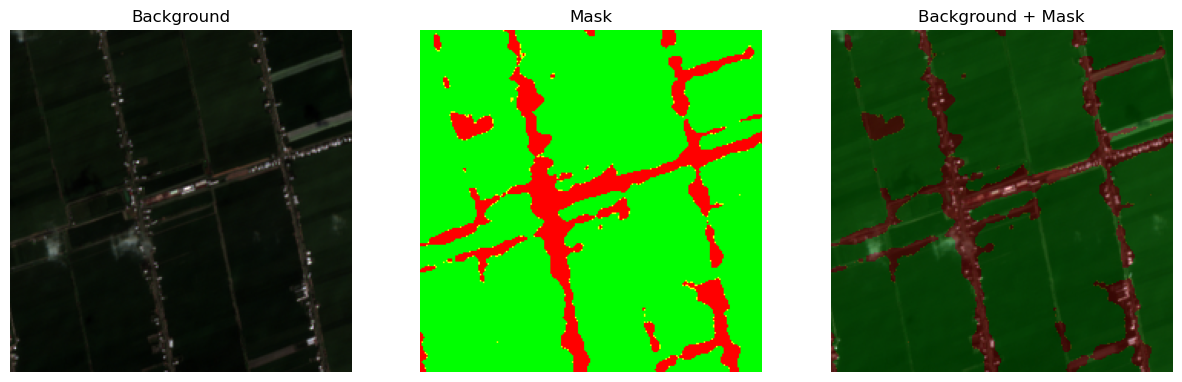

In [21]:
im = ims[2, :, :]
# Create figure and axes
fig, ax = plt.subplots(1, 3, figsize=(15, 15))

# Display the image
ax[0].imshow(im)
ax[1].imshow(mask, alpha=1)
ax[2].imshow(im)
ax[2].imshow(mask, alpha=.2)

ax[0].set_title("Background")
ax[1].set_title("Mask")
ax[2].set_title("Background + Mask")

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

plt.savefig("back + mask "+name+".png", transparent=True)

In [24]:
%%time
ims = get_backgound_image(settings)
rvi_im, rvi_date = get_full_window_rvi_no_pred(settings)
mask = rvi_im2cat_mask(rvi_im, rvi_date, 6)

Get background image
Get rvi image
Get mask
Get rvi
Interpolate
Predict
9696/9696 [==============================] - 43s 4ms/step
Get color
CPU times: user 2min 17s, sys: 36.6 s, total: 2min 54s
Wall time: 1min 24s


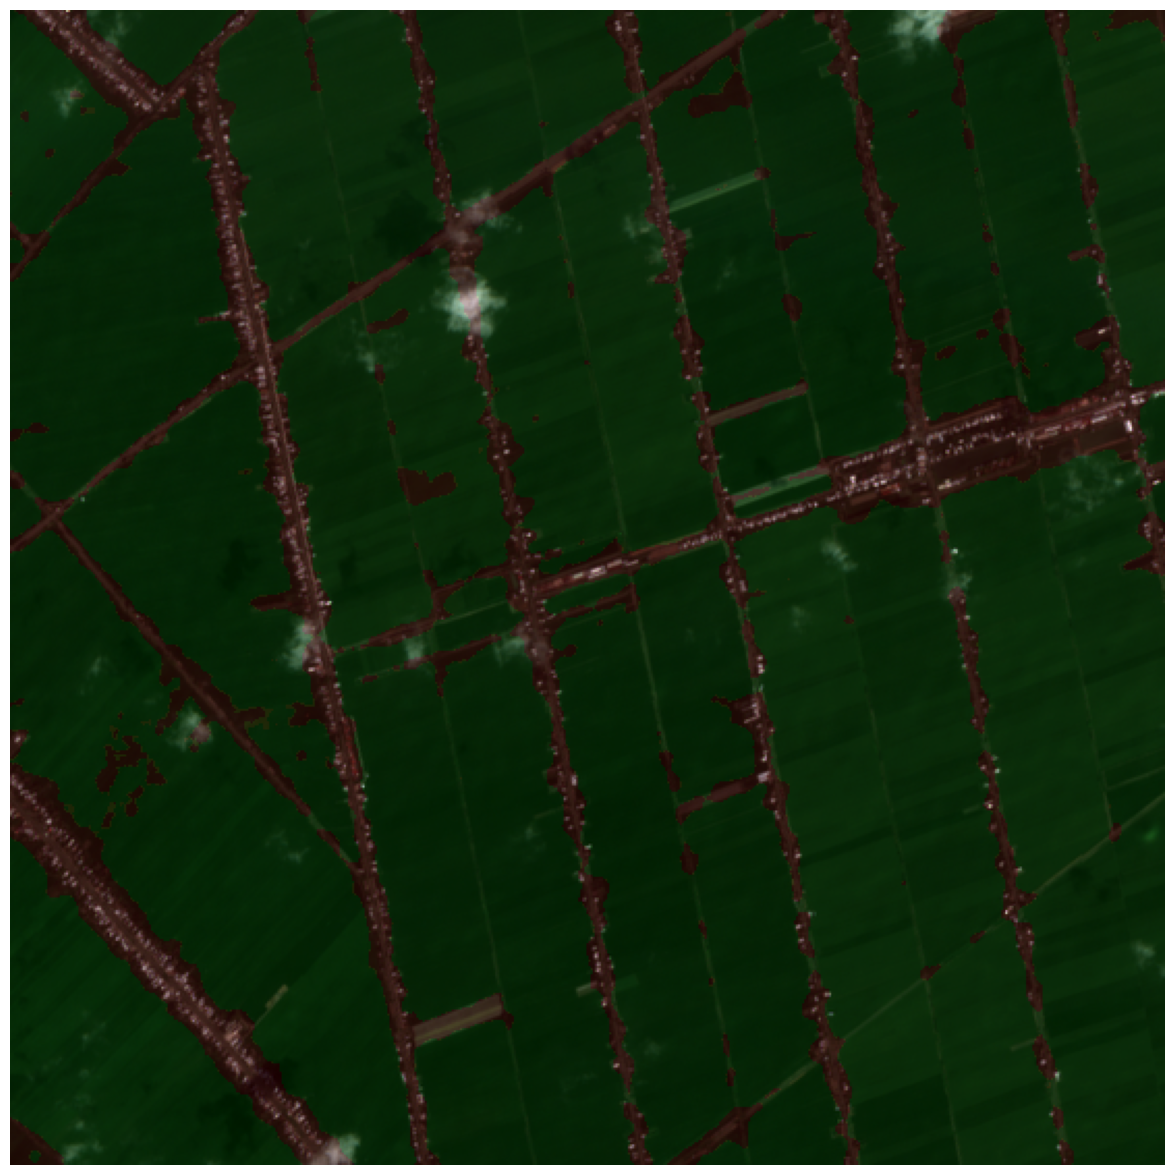

In [12]:
# V2
im = ims[2, :, :, :]

# Create figure and axes
fig, ax = plt.subplots(figsize=(15, 15))

# Display the image
ax.imshow(im)
ax.imshow(mask, alpha=.1)

plt.axis('off')
#plt.savefig("image "+opt+".png", transparent=True)
plt.show()